<a href="https://colab.research.google.com/github/nataliasiennicka/klasyfikacja_przyznania_karty_kredytowej/blob/main/przyznanie_karty_kredytowej.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem do rozwiązania:

####Problemem, do rozwiązania za pomocą modeli ML jest przyznanie bądź też odrzucenie przyznania danej osobie karty kredytowej. Ostatnia kolumna w zbiorze danych 'default payment next month' jest kolumną, która jest targetem (na jej podstawie określa się czy karta jest przyznana czy też nie.

In [135]:
                                    #Instalacja modułu do odczytania w pandasie xls
# !pip install --upgrade xlrd
# !pip install xlrd
# !pip install --upgrade openpyxl

#IMPORTY

In [136]:
import pandas as pd #biblioteka pandas do pracy na Data Frame
import numpy as np #biblioteka do obliczeń
import matplotlib.pyplot as plt #biblioteka do rysowania wykresów
%matplotlib inline
import seaborn as sns #biblioteka do rysowania wykresów

from sklearn.model_selection import train_test_split #do rozdzielenia danych na zbiór treningowy i testowy
from sklearn.preprocessing import StandardScaler, OneHotEncoder #do standaryzacji danych
from sklearn.model_selection import GridSearchCV #sprawdzanie kombinacji parametrów
from sklearn.pipeline import make_pipeline #tworzenie przepływu danych i uczenia modelu na nich
from sklearn.linear_model import LogisticRegression #regresja logistyczna
from sklearn.tree import DecisionTreeClassifier #model drzewa decyzyjnego


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc,roc_auc_score, classification_report #do oceny modelu
from scipy import stats

#FUNKCJE

In [137]:
#Rysowanie wykresów
def print_corelogram(X,size):
  plt.figure(figsize=size)
  ax = sns.heatmap(X.corr(), 
                  xticklabels=X.corr().columns, 
                  yticklabels=X.corr().columns, 
                  cmap='BuGn', 
                  center=0, 
                  annot=True)

  plt.title('Correlogram of data', fontsize=22)
  bottom, top = ax.get_ylim()
  ax.set_ylim(bottom + 0.5, top - 0.5)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.show()


def analize_feature(dataframe, col, target):

  #Histogram
  import warnings
  warnings.filterwarnings("ignore")

  plt.figure(figsize=(10,7))
  sns.distplot(dataframe[col], 
               kde=True, 
               rug=False)
  plt.title(f'Histogram of {col}')
  plt.show()

  print()

    #BoxPlot
  plt.figure(figsize=(10,7))
  sns.boxplot(data=dataframe, y=col, x= target)
  plt.title(f'Boxplot for {col} where default payment next month is 0 or 1')
  plt.show()
  print()

    #ViolinPlot
  plt.figure(figsize=(10,7))
  sns.set_style('whitegrid')
  sns.violinplot(data=dataframe, 
                 y=col, 
                 x= target,
                 inner=None)
  plt.title(f'Violinplot for {col} where default payment next month is 0 or 1')
  plt.show()
  

In [138]:
#Ocena modelu

def clasiffication_metrics(true, prediction):
    print(f'Accuracy: {accuracy_score(true, prediction)}')
    print(f'Precision: {precision_score(true, prediction)}')
    print(f'Recall: {recall_score(true, prediction)}')
    print(f'F1-score: {f1_score(true, prediction)}')
    print()

    cm_test = confusion_matrix(true, prediction)
    sns.heatmap(cm_test, annot=True, fmt='d')
    plt.title('Macierz omyłek dla utworzonego modelu')
    plt.show()



In [139]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe

models = []
models_names = []

def calculate_metrics(model, name):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_test)
    predictions_proba = model.predict_proba(X_test)
    
    ############## metrics for checked model ################
    # Precision, Recall, F1
    print(classification_report(y_test, predictions))
    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_test, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()
    # ROC
    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected in zip(models, models_names):
        fpr, tpr, thresholds = roc_curve(y_test, model_selected.predict_proba(X_test)[:,1])
        plt.plot(fpr, tpr, label=name_selected)
        
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    
    f1_metric = f1_score(y_test, predictions)
    auc_metric = roc_auc_score(y_test, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

#Wczytanie danych

Poniższe dane zawierają kategorie na podstawie których wykonane zostaną modele uczenia maszynowego. Są to:
- X1: kwota kredytu (w $) obejmuje kredyt przyznany pojedynczej osobie jak i całej rodzinie

- X2: płeć (1 = mężczyzna; 2 = kobieta)

- X3: wykształcenie (1 = graduate school; 2 = university; 3 = high school; 4 = others)

- X4: stan cywilny (1 = zamężny/żonaty; 2 = singiel; 3 = inny)

- X5: wiek (w latach)

- X6 - X11: historia płatności (od kwietnia do września, gdzie X6 = stan słaty we wrześniu, 7 = stan spłaty w sierpniu)

- X11 = stan spłaty określona na kwiecień, gdzie liczbowo wyrażona jest liczba miesięcy w opóźnieniu spłaty (1 = opóźnienie w płatności o jeden miesiąc; 2 = dwumiesięczna zwłoka w płatności, itd.)

- X12-X17: kwota wyciągu z rachunku w kolejnych miesiącach (X12 = kwota wyciągu z rachunku we wrześniu, X13 = kwota wyciągu z rachunku w sierpniu, ..., X17 =kwota wyciągu z rachunku w kwietniu

- X18-X23: kwota poprzedniej płatności (w kolejnych miesiącach X18 = kwota wypłacona we wrześniu, X19 = kwota wypłacona w sierpniu, X23 = kwota wypłacona w kwietniu)

Wszystkie powyższe dane są danymi na rok 2005.

In [140]:
!git clone https://github.com/nataliasiennicka/klasyfikacja_przyznania_karty_kredytowej

fatal: destination path 'klasyfikacja_przyznania_karty_kredytowej' already exists and is not an empty directory.


In [141]:
#nazwy kolumn zostały zastąpione wierszem z rozwiniętą nazwą zamiast kategorii X[...] natomiast z numeru ID utworzono indeks danej obserwacji

card = pd.read_excel('klasyfikacja_przyznania_karty_kredytowej/card.xls',keep_default_na = False, index_col=0, skiprows=1)
card

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


Nadanie nazwy kolumnie, która jest targetem:

Z racji tego, że przy przyznaniu karty kredytowej płeć nie powinna mieć wpływu na decyzję od razu odrzucono analizowanie tej kategorii w dalszej części projektu. 

In [142]:
#odrzucenie kategorii 'SEX'
card = card.drop(columns='SEX')

#Eksploracyjna analiza danych

In [143]:
card.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 1 to 30000
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   EDUCATION                   30000 non-null  int64
 2   MARRIAGE                    30000 non-null  int64
 3   AGE                         30000 non-null  int64
 4   PAY_0                       30000 non-null  int64
 5   PAY_2                       30000 non-null  int64
 6   PAY_3                       30000 non-null  int64
 7   PAY_4                       30000 non-null  int64
 8   PAY_5                       30000 non-null  int64
 9   PAY_6                       30000 non-null  int64
 10  BILL_AMT1                   30000 non-null  int64
 11  BILL_AMT2                   30000 non-null  int64
 12  BILL_AMT3                   30000 non-null  int64
 13  BILL_AMT4                   30000 non-null  int64
 14  BILL_A

Na podstawie podstawowych informacjach o danych można zauważyć, że:
- w zbiorze danych jest 30000 obserwacji;
- brak jest wartości pustych;
- wszystkie dane są wartościmy liczbowymi (int64)
- w zbiorze danych jest 23 kategorie, z których należy wybrać te, które zostaną wykorzystane do modelu

In [144]:
card.describe()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


Do wstępnej oceny określenia, które w kategorie należy uwzględnić w analizie posłuży heatmapa, która określi jak silnie dane wpływają na target.

In [145]:
categorical_features = ['EDUCATION', 'MARRIAGE']
numeric_features = ['LIMIT_BAL', 'AGE', 
            'PAY_0', 'PAY_2', 'PAY_3','PAY_4', 'PAY_5', 'PAY_6', 
            'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3','BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
            'PAY_AMT1', 'PAY_AMT2','PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [146]:
card_numeric_features=card.copy()
card_numeric_features=card_numeric_features.drop(columns='EDUCATION')
card_numeric_features=card_numeric_features.drop(columns='MARRIAGE')

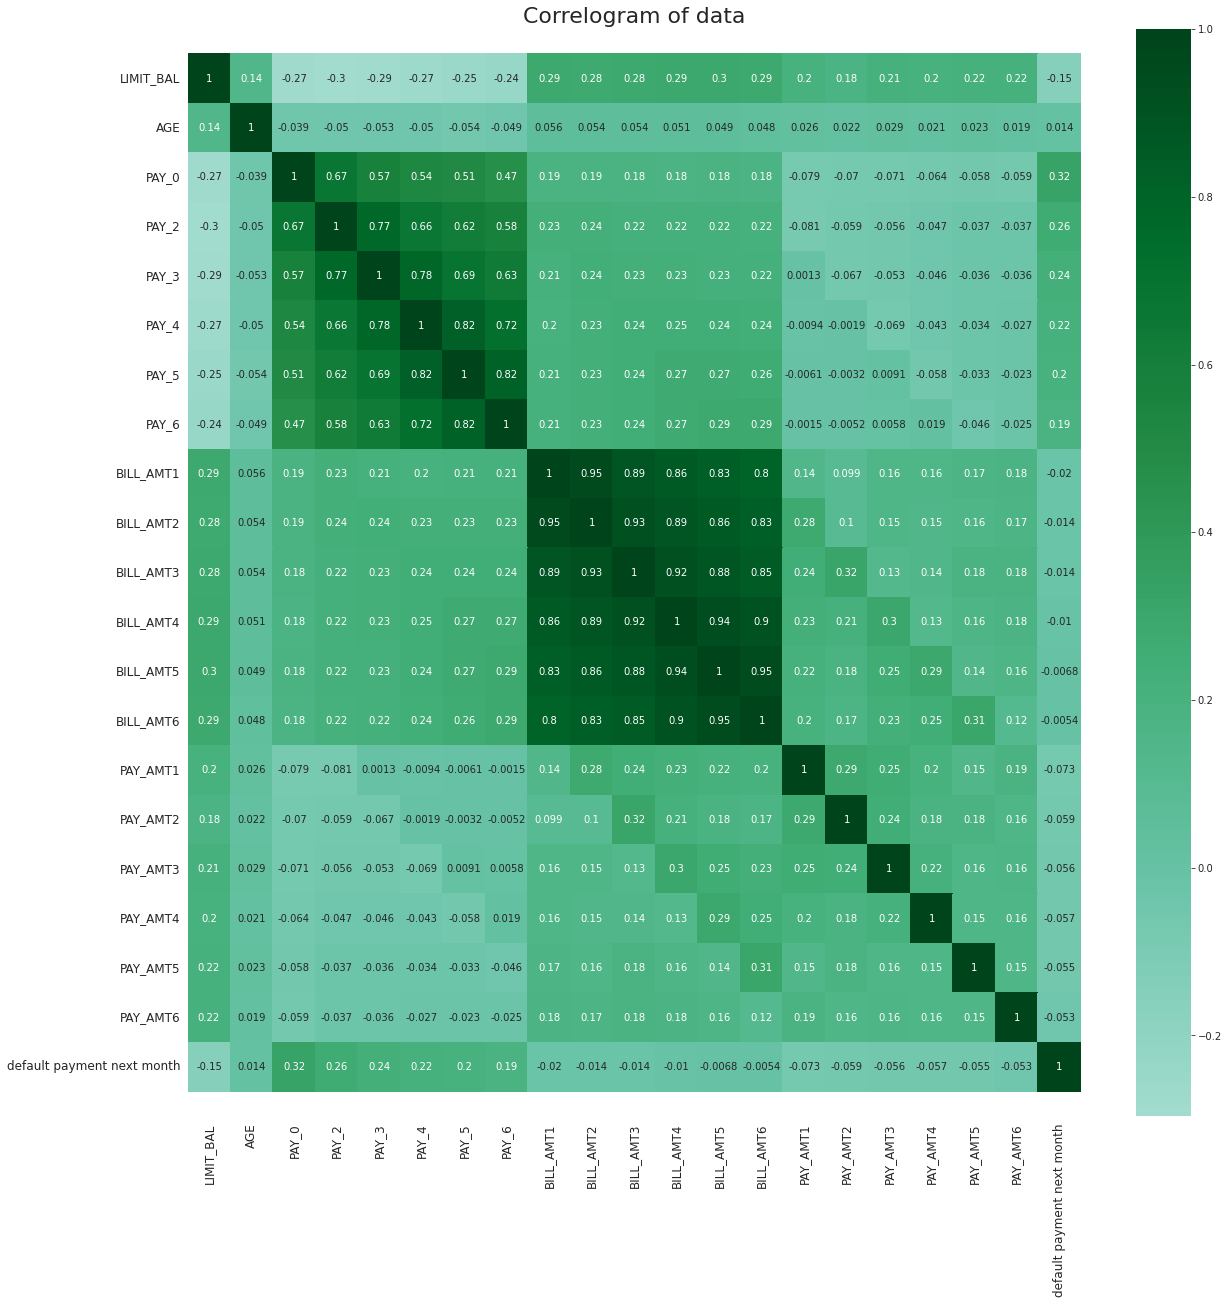

In [147]:
print_corelogram(card_numeric_features,size=(20, 20))

Point Biserial - do porówywania zmiennych kategorycznych i numerycznych  ---> do zrobienia

Na podstawie powyższego korelogramu można zaobserwować, że każda zmienna ma wpływ na założony target. Najmniej skoralowany jest on z kolumnami: 'AGE' oraz 'BILL_ATM2' do 'BILL_ATM6'(stan spłaty w kolejnych miesiącach). Zdecydowano jednak, że dane te nie są na tyle nieistotne aby je odrzucić. Należy bliżej przyjrzeć się poszczególnym kategoriom.

##LIMIT_BAL - kwota kredytu, która została przyznana

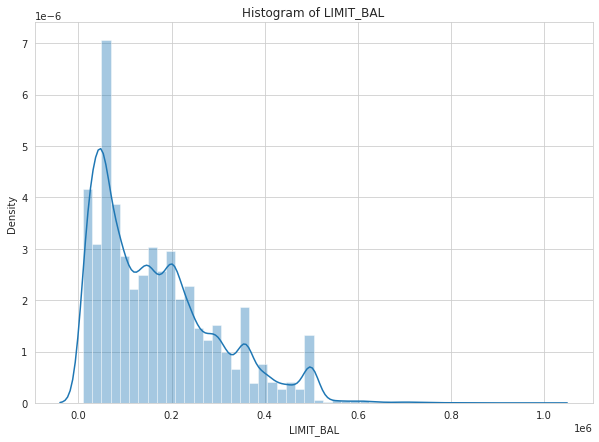

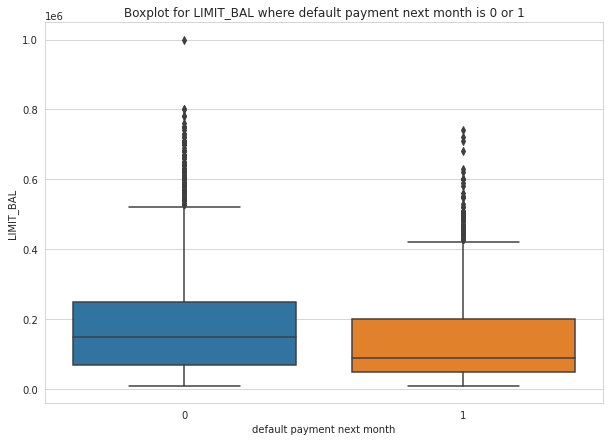

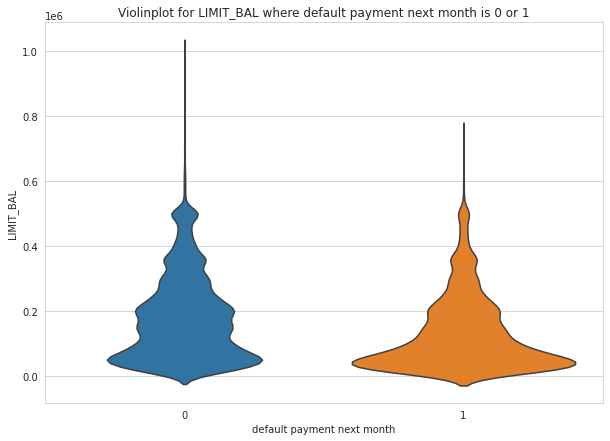

In [148]:
analize_feature(card, 'LIMIT_BAL', 'default payment next month')

Na podstawie wykresów można odczytać, że najwięcej kredytów przyznano grupie osób, których kwota przyznanego kredytu była dosyć niska. Widać tu zależność, im wyższa kwota kredytu tym mniejsza szansa na przyznanie karty kredytowej.


##EDUCATION

In [149]:
card.value_counts(['EDUCATION'], sort=False)

EDUCATION
0               14
1            10585
2            14030
3             4917
4              123
5              280
6               51
dtype: int64

Na podstawie powyższej informacji o ilości obserwacji w każdej grupie, zauważono, że istnieją obserwacji w grupach, które nie zostały opisane jako kategoria: 1 = graduate school; 2 = university; 3 = high school; 4 = others

Zdecydowano grupę 0, 5 oraz 6 należy zamienić na 4 = others

In [150]:
#Zaiana błędnych wartości
card['EDUCATION'] = card['EDUCATION'].replace({0: 4, 5: 4, 6: 4}, regex=True)

In [151]:
card.value_counts(['EDUCATION'], sort=False)

EDUCATION
1            10585
2            14030
3             4917
4              468
dtype: int64

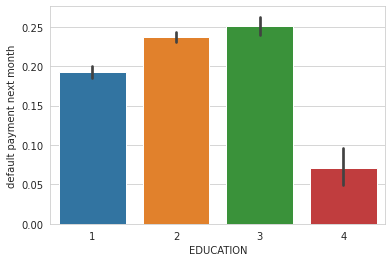

In [152]:
sns.barplot(x='EDUCATION', y='default payment next month',data=card)

##MARRIAGE	

In [153]:
#ilość obserwacji w poszczególnych klasach
card.value_counts(['MARRIAGE'], sort=False)

MARRIAGE
0              54
1           13659
2           15964
3             323
dtype: int64

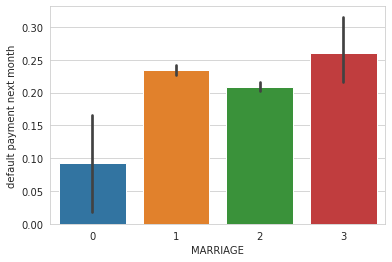

In [154]:
sns.barplot(x='MARRIAGE', y='default payment next month',data=card)

##AGE

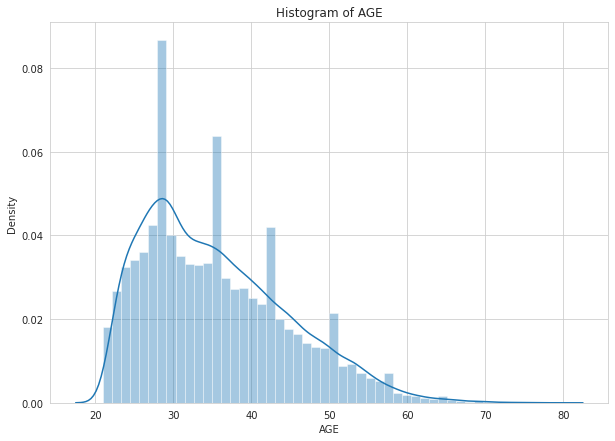

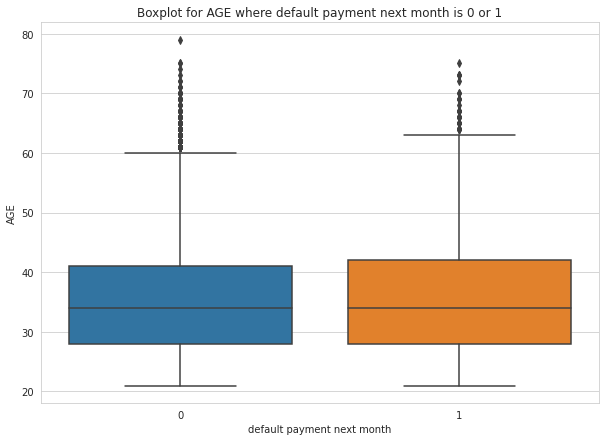

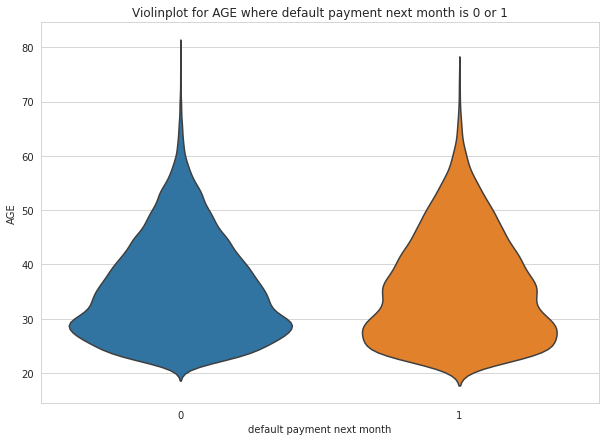

In [155]:
analize_feature(card, 'AGE', 'default payment next month')

Jeżeli chodzi o wpływ wieku na staranie się o przyznanie karty kredtytowej, widać pewną zeleżność(od 30 roku życia coraz mniej osób stara się o taką kartę) Jednak czy wiek ma wpływ na decyzję o jej przyznaniu? na podstawie wykresu skrzypcowego, można zauważyć minimalną różninicę w rozkładzie ilości przyznanych kart (szczególnie w okolicach 35 roku życia, wykres rozszerza się, a powiędzy 30 a 50 jest znacznie łagodniejszy dla grupy, która otrzymała kartę niż dla grupy, która jej nie otrzymała). Różnica występuje różnież największej wartości wieku osoby, która nie otrzymała karty oraz największej wartości osoby, która taką kartę otrzymała. Można wywniosokować z tego, że po przekroczeniu pewnego wieku, karta kredytowa nie jest przyznawana. 

##PAY

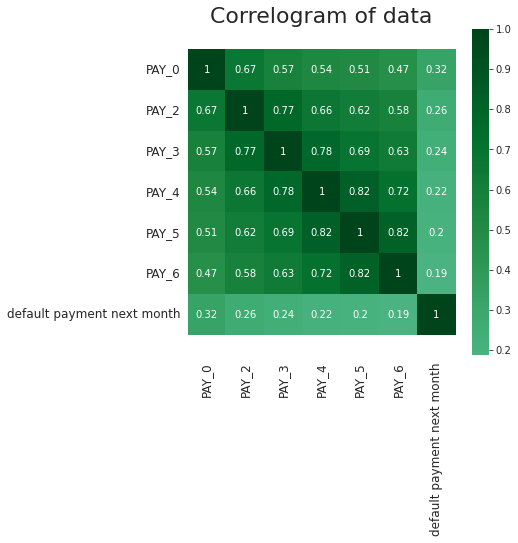

In [156]:
pay = card.loc[:, ['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','default payment next month']]

print_corelogram(pay,size=(6, 6))

Analizując jedynie korelogram zależności widać, że największy wpływ na przyznanie karty ma kolumna PAY_0, która jest ostatnim miesiącem ze wszystkich analizowanych (wrzesień) można też zaobserwować, że wszystkie kolumny PAY zależą wzajemnie od siebie.

##BILL_AMT

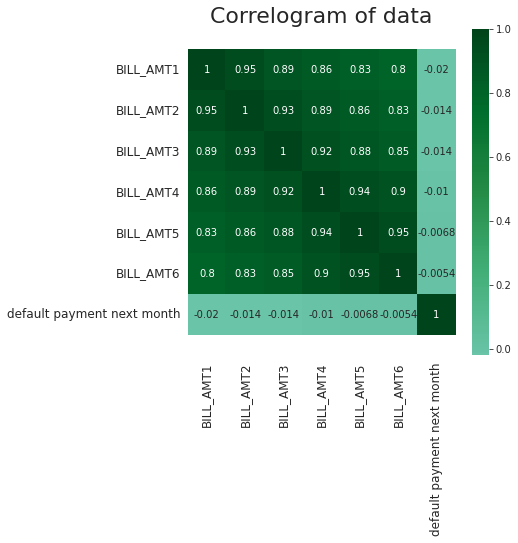

In [157]:
bill_atm = card.loc[:, ['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6','default payment next month']]

print_corelogram(bill_atm,size=(6, 6))

Kwota wyciągu z rachunku również jest natomiast odwrotnie skorelowana pomiędzy decyzją o przyznaniu karty. Oznacza to, że im późniejszy miesiąc tym korelacja pomiądzy zmienną a targetem jest większa. 

##PAY_AMT

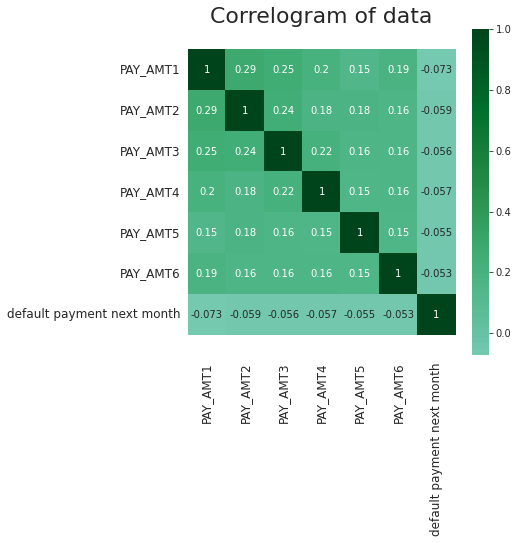

In [158]:
pay_atm = card.loc[:, ['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6','default payment next month']]

print_corelogram(pay_atm,size=(6, 6))

Kwota poprzedniej płatności wygląda podobnie jak poprzednie korelogramy. Największy wpływ na przyznanie karty mają ostatnie zanotowane w danych miesiące, oraz wartości w kolejnych miesiącach są od siebie zeleżne.

#Podział na X i y

Zamiana danych kategorycznych na wartości 0 i 1

In [159]:
education = pd.get_dummies(card['EDUCATION'], drop_first=True) #zamiana kategorii na 0/1

In [160]:
marriage = pd.get_dummies(card['MARRIAGE'], drop_first=True)

In [161]:
features = card.drop(columns={'EDUCATION','MARRIAGE'})
features=pd.concat([features,education],axis=1)


In [162]:
features = features.rename(columns={2:'EDUCATION2'})
features = features.rename(columns={3:'EDUCATION3'})
features = features.rename(columns={4:'EDUCATION4'})

In [163]:
features=pd.concat([features,marriage],axis=1)

In [164]:
features = features.rename(columns={1:'MARRIAGE1'})
features = features.rename(columns={2:'MARRIAGE2'})
features = features.rename(columns={3:'MARRIAGE3'})

In [165]:
y = features.pop('default payment next month')
X= features
display(X)
display(y)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION2,EDUCATION3,EDUCATION4,MARRIAGE1,MARRIAGE2,MARRIAGE3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,0,0,1,0,0,1,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,1000,1000,0,2000,1,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,1000,5000,1,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1200,1100,1069,1000,1,0,0,1,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,10000,9000,689,679,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,5003,3047,5000,1000,0,1,0,1,0,0
29997,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,8998,129,0,0,0,1,0,0,1,0
29998,30000,37,4,3,2,-1,0,0,3565,3356,...,22000,4200,2000,3100,1,0,0,0,1,0


ID
1        1
2        1
3        0
4        0
5        0
        ..
29996    0
29997    0
29998    1
29999    1
30000    1
Name: default payment next month, Length: 30000, dtype: int64

In [166]:
X

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION2,EDUCATION3,EDUCATION4,MARRIAGE1,MARRIAGE2,MARRIAGE3
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,0,0,0,0,1,0,0,1,0,0
2,120000,26,-1,2,0,0,0,2,2682,1725,...,1000,1000,0,2000,1,0,0,0,1,0
3,90000,34,0,0,0,0,0,0,29239,14027,...,1000,1000,1000,5000,1,0,0,0,1,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,1200,1100,1069,1000,1,0,0,1,0,0
5,50000,57,-1,0,-1,0,0,0,8617,5670,...,10000,9000,689,679,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,5003,3047,5000,1000,0,1,0,1,0,0
29997,150000,43,-1,-1,-1,-1,0,0,1683,1828,...,8998,129,0,0,0,1,0,0,1,0
29998,30000,37,4,3,2,-1,0,0,3565,3356,...,22000,4200,2000,3100,1,0,0,0,1,0


#Podział danych na treningowe oraz testowe

In [167]:
card['default payment next month'].value_counts(normalize=True)

0    0.7788
1    0.2212
Name: default payment next month, dtype: float64

In [168]:
# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0, stratify=y)

print ('Training cases: %d\nTest cases: %d' % (X_train.shape[0], X_test.shape[0]))

Training cases: 21000
Test cases: 9000


Zbiór danych treningowych uległ  standaryzacji (dane nie muszą być standaryzowane dla modeli TreeModel i RandomForest)

# Baseline

In [169]:
#stworzenie modwlu baselina do którego będą poeównywane inne modele (model jest stworzony na podstawie regresjii logistycznej, na danych bez standaryzcji)
baseline = LogisticRegression()
baseline.fit(X_train, y_train)

LogisticRegression()

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7009
           1       0.33      0.00      0.00      1991

    accuracy                           0.78      9000
   macro avg       0.56      0.50      0.44      9000
weighted avg       0.68      0.78      0.68      9000



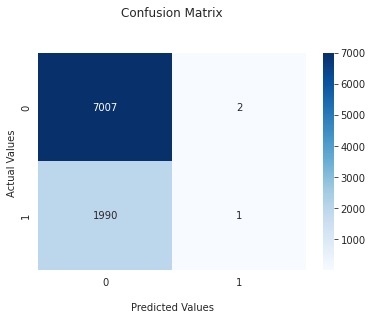

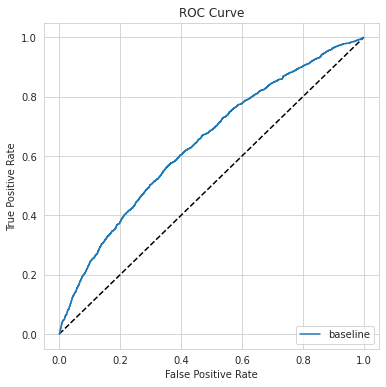

,Model,F1_score,AUC
0,baseline,0.001003,0.642373


In [170]:
calculate_metrics(baseline, 'baseline')

#Standaryzacja i udersapling zbiorów danych

Standaryzację wykonuje się na potrzeby modeli parametrycznych, takich jak: SVM, modele regresji, k-najbliższych sąsiadów. Modele oparte na drzewach (drzewo decyzyjne i fandom forest) nie potrzebują standaryzacji danych, jednak standaryzacja nie wpływa na nie niekorzystnie.

Poniżej wykonano standaryzację zbiorów z których korzystano we wszystkich modelach.

Zdecydowano się także na uder sampling, aby zbiory danych były zbalansowane (to znacy zawierały podobną liczbę targetów odpowiadających każdej z kategorii)

Dla porównania modele wykonano także na danych niezbalansowanych.

In [171]:
#Standaryzacja

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features]) #Standard Stacer fitujemy do zbioru treningowego (ponieważ, zakładamy, że dal tego zbioru znamy średnią, a zbiór testowy jest nieznany)
X_test[numeric_features] = scaler.transform(X_test[numeric_features]) #Na zbiorze testowym jedynie robimy fransformację, nie fitujemy na tym zbiorze!!!

In [172]:
#UNDERSAMPLING
from imblearn import under_sampling
from imblearn.under_sampling import RandomUnderSampler
#dla klasy, której jest wiecej zostanie usunięta
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=2022) 
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

pd.Series(y_train_under).value_counts()#rozkład klas po zrobieniu undersamplingu

0    4645
1    4645
Name: default payment next month, dtype: int64

#Regresja logistyczna

## Bez undersamplingu

In [173]:
rl_model = LogisticRegression()
# Nasz model sprawdzi poniższe hiperparametry
params = {'C': [0.001, 0.05, 0.01, 0.1, 1, 1.1, 1.5, 2]}

rl_model_gridsearch = GridSearchCV(rl_model,
                                   params,
                                   scoring='f1_macro',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
rl_model_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rl_model_gridsearch.best_params_)

rl_model = rl_model_gridsearch.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START C=0.001....................................................
[CV 1/10; 1/8] END .....................C=0.001;, score=0.592 total time=   0.1s
[CV 2/10; 1/8] START C=0.001....................................................
[CV 2/10; 1/8] END .....................C=0.001;, score=0.572 total time=   0.1s
[CV 3/10; 1/8] START C=0.001....................................................
[CV 3/10; 1/8] END .....................C=0.001;, score=0.564 total time=   0.1s
[CV 4/10; 1/8] START C=0.001....................................................
[CV 4/10; 1/8] END .....................C=0.001;, score=0.575 total time=   0.1s
[CV 5/10; 1/8] START C=0.001....................................................
[CV 5/10; 1/8] END .....................C=0.001;, score=0.571 total time=   0.1s
[CV 6/10; 1/8] START C=0.001....................................................
[CV 6/10; 1/8] END .....................C=0.001;

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.72      0.24      0.36      1991

    accuracy                           0.81      9000
   macro avg       0.77      0.61      0.62      9000
weighted avg       0.80      0.81      0.77      9000



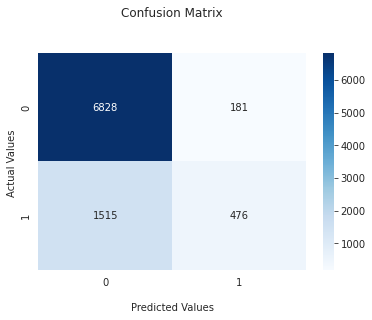

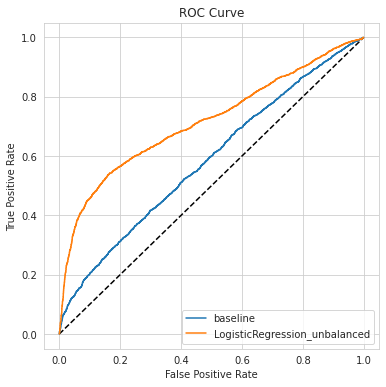

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106


In [174]:
calculate_metrics(rl_model, 'LogisticRegression_unbalanced')

## Po undersamplingi

In [175]:
rl_model_under = LogisticRegression()
# Nasz model sprawdzi poniższe hiperparametry
params = {'C': [0.001, 0.05, 0.01, 0.1, 1, 1.1, 1.5, 2]}

rl_model_under_gridsearch = GridSearchCV(rl_model_under,
                                   params,
                                   scoring='f1_macro',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
rl_model_under_gridsearch.fit(X_train_under, y_train_under)
print('\nBest hyperparameter:', rl_model_under_gridsearch.best_params_)

rl_model_under = rl_model_under_gridsearch.best_estimator_

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START C=0.001....................................................
[CV 1/10; 1/8] END .....................C=0.001;, score=0.674 total time=   0.0s
[CV 2/10; 1/8] START C=0.001....................................................
[CV 2/10; 1/8] END .....................C=0.001;, score=0.647 total time=   0.0s
[CV 3/10; 1/8] START C=0.001....................................................
[CV 3/10; 1/8] END .....................C=0.001;, score=0.650 total time=   0.0s
[CV 4/10; 1/8] START C=0.001....................................................
[CV 4/10; 1/8] END .....................C=0.001;, score=0.661 total time=   0.0s
[CV 5/10; 1/8] START C=0.001....................................................
[CV 5/10; 1/8] END .....................C=0.001;, score=0.645 total time=   0.0s
[CV 6/10; 1/8] START C=0.001....................................................
[CV 6/10; 1/8] END .....................C=0.001;

              precision    recall  f1-score   support

           0       0.87      0.68      0.76      7009
           1       0.36      0.64      0.47      1991

    accuracy                           0.67      9000
   macro avg       0.62      0.66      0.61      9000
weighted avg       0.76      0.67      0.70      9000



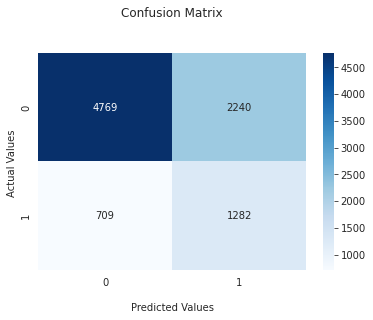

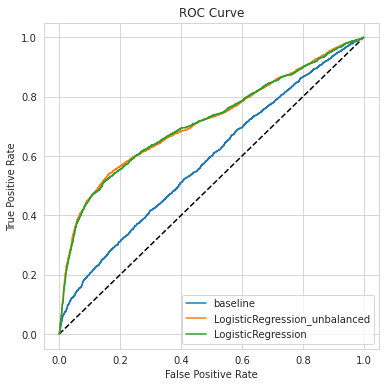

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262


In [176]:
calculate_metrics(rl_model_under, 'LogisticRegression')

#Drzewo decyzyjne

## Bez undersamplingu

In [177]:
tree_model = DecisionTreeClassifier()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1, 2, 5, 7, 10]}

tree_model_gridsearch = GridSearchCV(tree_model, 
                                                params,
                                                scoring='f1_macro',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
tree_model_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', tree_model_gridsearch.best_params_)

tree_model = tree_model_gridsearch.best_estimator_

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 1/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.675 total time=   0.0s
[CV 2/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 2/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.669 total time=   0.0s
[CV 3/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 3/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.655 total time=   0.0s
[CV 4/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 4/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.664 total time=   0.0s
[CV 5/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 5/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.657 total time=   0.0s
[CV 6/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 6/10; 1/75] END max_de

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.63      0.36      0.46      1991

    accuracy                           0.81      9000
   macro avg       0.73      0.65      0.67      9000
weighted avg       0.79      0.81      0.79      9000



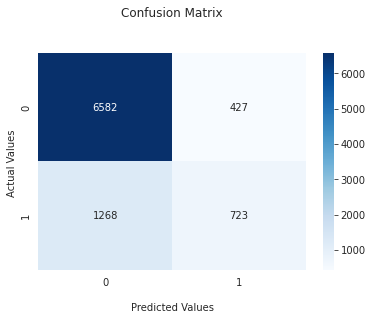

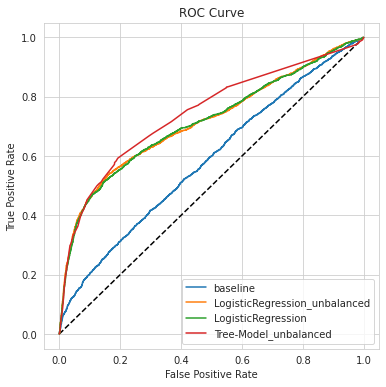

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262
3,Tree-Model_unbalanced,0.460363,0.744358


In [178]:
calculate_metrics(tree_model, 'Tree-Model_unbalanced')

## Po undersamplingu

In [179]:
tree_model_under = DecisionTreeClassifier()
# Nasz model sprawdzi poniższe hiperparametry
params = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1, 2, 5, 7, 10]}

tree_model_under_gridsearch = GridSearchCV(tree_model_under, 
                                                params,
                                                scoring='f1_macro',
                                                cv=10,
                                                verbose=10)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
tree_model_under_gridsearch.fit(X_train_under, y_train_under)
print('\nBest hyperparameter:', tree_model_under_gridsearch.best_params_)

tree_model_under = tree_model_under_gridsearch.best_estimator_

Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 1/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.693 total time=   0.0s
[CV 2/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 2/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.648 total time=   0.0s
[CV 3/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 3/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.647 total time=   0.0s
[CV 4/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 4/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.666 total time=   0.0s
[CV 5/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 5/10; 1/75] END max_depth=1, min_samples_leaf=1;, score=0.669 total time=   0.0s
[CV 6/10; 1/75] START max_depth=1, min_samples_leaf=1...........................
[CV 6/10; 1/75] END max_de

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      7009
           1       0.49      0.54      0.51      1991

    accuracy                           0.77      9000
   macro avg       0.68      0.69      0.68      9000
weighted avg       0.78      0.77      0.78      9000



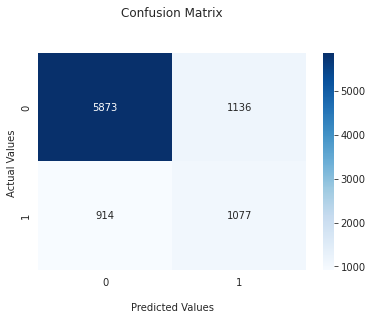

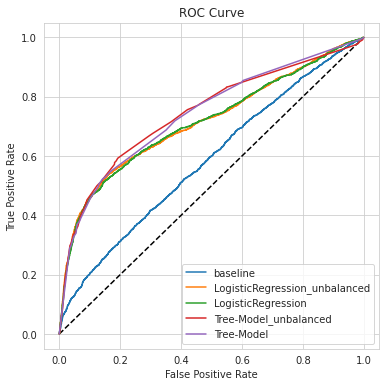

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262
3,Tree-Model_unbalanced,0.460363,0.744358
4,Tree-Model,0.512369,0.741218


In [180]:
calculate_metrics(tree_model_under, 'Tree-Model')

#Random Forest

##Bez undersamplingu

In [181]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1)

params_rf = {'max_depth': [2, 3, 5, 10, 20],
             'min_samples_leaf': [10, 25, 50]}

rf_gridsearch = GridSearchCV(random_forest,
                             params_rf, 
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)

rf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', rf_gridsearch.best_params_)

rf_model = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best hyperparameter: {'max_depth': 20, 'min_samples_leaf': 25}


              precision    recall  f1-score   support

           0       0.84      0.95      0.89      7009
           1       0.68      0.35      0.46      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.82      0.80      9000



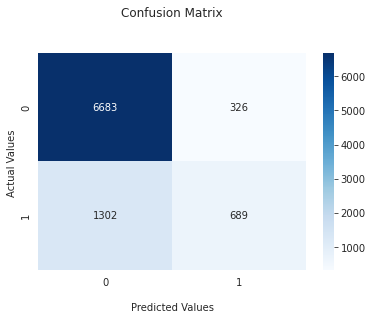

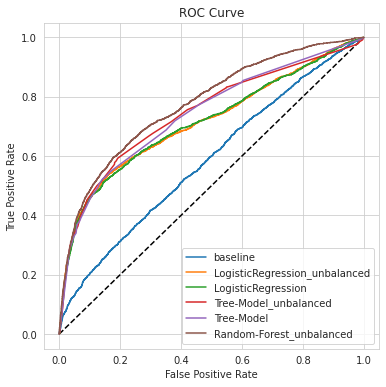

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262
3,Tree-Model_unbalanced,0.460363,0.744358
4,Tree-Model,0.512369,0.741218
5,Random-Forest_unbalanced,0.458417,0.776204


In [182]:
calculate_metrics(rf_model, 'Random-Forest_unbalanced')

## Po undersamplingu

In [183]:
random_forest_under = RandomForestClassifier(n_estimators=50, n_jobs=-1)

params_rf = {'max_depth': [2, 3, 5, 10, 20],
             'min_samples_leaf': [10, 25, 50]}

rf_under_gridsearch = GridSearchCV(random_forest_under,
                             params_rf, 
                             scoring='f1_macro',
                             cv=5,
                             verbose=10, n_jobs=-1)

rf_under_gridsearch.fit(X_train_under, y_train_under)
print('\nBest hyperparameter:', rf_under_gridsearch.best_params_)

rf_model_under = rf_under_gridsearch.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best hyperparameter: {'max_depth': 20, 'min_samples_leaf': 50}


              precision    recall  f1-score   support

           0       0.88      0.78      0.83      7009
           1       0.45      0.63      0.53      1991

    accuracy                           0.75      9000
   macro avg       0.67      0.71      0.68      9000
weighted avg       0.79      0.75      0.76      9000



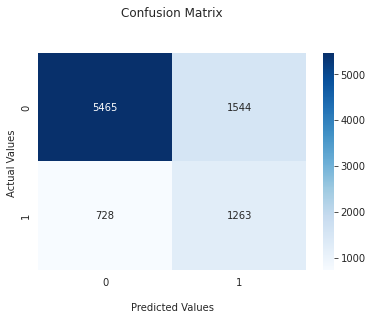

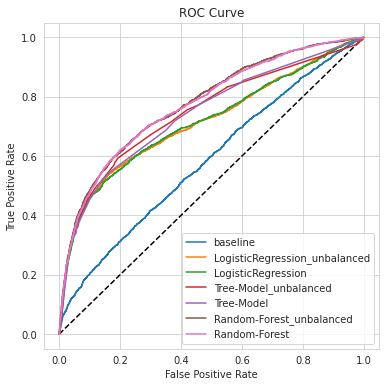

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262
3,Tree-Model_unbalanced,0.460363,0.744358
4,Tree-Model,0.512369,0.741218
5,Random-Forest_unbalanced,0.458417,0.776204
6,Random-Forest,0.526469,0.773831


In [184]:
calculate_metrics(rf_model_under, 'Random-Forest')

#Model Boostingowy

## Bez undersamplingu

In [185]:
from sklearn.ensemble import AdaBoostClassifier

clf_model = AdaBoostClassifier()

params_clf = {'n_estimators': [50,100,150],
             'learning_rate': [0.1,0.3,0.6,0.9,1]}

clf_gridsearch = GridSearchCV(clf_model,
                             params_clf,
                            scoring='f1_macro', 
                             cv=5,
                             verbose=10, 
                              n_jobs=-1)

clf_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', clf_gridsearch.best_params_)

clf_model = clf_gridsearch.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best hyperparameter: {'learning_rate': 0.6, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.84      0.96      0.89      7009
           1       0.69      0.34      0.45      1991

    accuracy                           0.82      9000
   macro avg       0.76      0.65      0.67      9000
weighted avg       0.80      0.82      0.79      9000



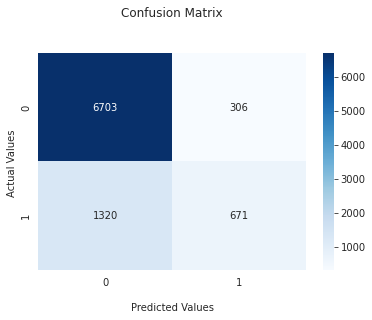

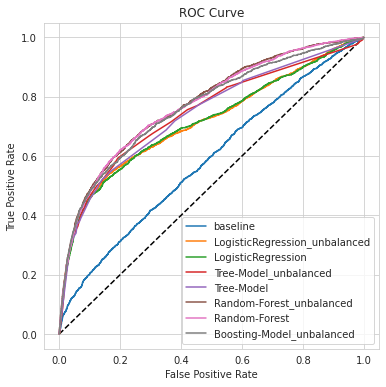

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262
3,Tree-Model_unbalanced,0.460363,0.744358
4,Tree-Model,0.512369,0.741218
5,Random-Forest_unbalanced,0.458417,0.776204
6,Random-Forest,0.526469,0.773831
7,Boosting-Model_unbalanced,0.452156,0.764917


In [186]:
calculate_metrics(clf_model, 'Boosting-Model_unbalanced')

##Po undersamplingu

In [187]:
clf_model_under = AdaBoostClassifier()

params_clf = {'n_estimators': [50,100,150],
             'learning_rate': [0.1,0.3,0.6,0.9,1]}

clf_under_gridsearch = GridSearchCV(clf_model_under,
                             params_clf,
                            scoring='f1_macro', 
                             cv=5,
                             verbose=10, 
                              n_jobs=-1)

clf_under_gridsearch.fit(X_train_under, y_train_under)
print('\nBest hyperparameter:', clf_under_gridsearch.best_params_)

clf_model_under = clf_under_gridsearch.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best hyperparameter: {'learning_rate': 0.6, 'n_estimators': 100}


              precision    recall  f1-score   support

           0       0.87      0.80      0.83      7009
           1       0.46      0.60      0.52      1991

    accuracy                           0.75      9000
   macro avg       0.66      0.70      0.68      9000
weighted avg       0.78      0.75      0.76      9000



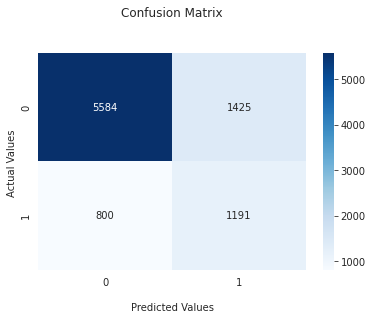

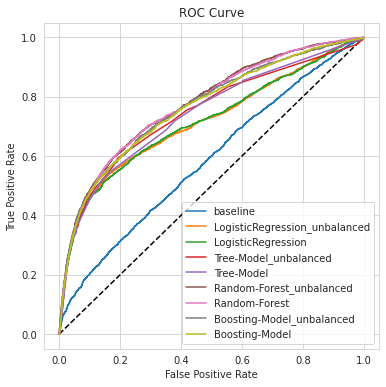

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262
3,Tree-Model_unbalanced,0.460363,0.744358
4,Tree-Model,0.512369,0.741218
5,Random-Forest_unbalanced,0.458417,0.776204
6,Random-Forest,0.526469,0.773831
7,Boosting-Model_unbalanced,0.452156,0.764917
8,Boosting-Model,0.517039,0.761915


In [188]:
calculate_metrics(clf_model_under, 'Boosting-Model')

#SVM

##Bez undersamplingu

In [189]:
from sklearn.svm import SVC
#svm_model = SVC()
# Nasz model sprawdzi poniższe hiperparametry

params = {'C':[ 0.01, 0.1, 1]}
svm_model = SVC(kernel='poly', probability=True)

svm_model_gridsearch = GridSearchCV(svm_model, 
                                                params,
                                                scoring='f1_macro',
                                                cv=10,
                                                verbose=10,
                                                n_jobs=-1)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
svm_model_gridsearch.fit(X_train, y_train)
print('\nBest hyperparameter:', svm_model_gridsearch.best_params_)

svm_model = svm_model_gridsearch.best_estimator_

Fitting 10 folds for each of 3 candidates, totalling 30 fits

Best hyperparameter: {'C': 1}


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.70      0.27      0.39      1991

    accuracy                           0.81      9000
   macro avg       0.76      0.62      0.64      9000
weighted avg       0.80      0.81      0.78      9000



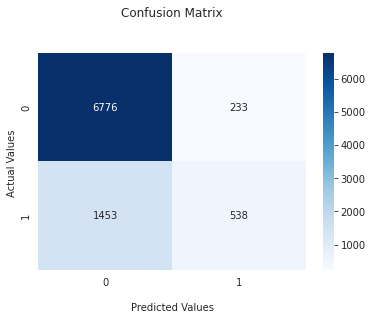

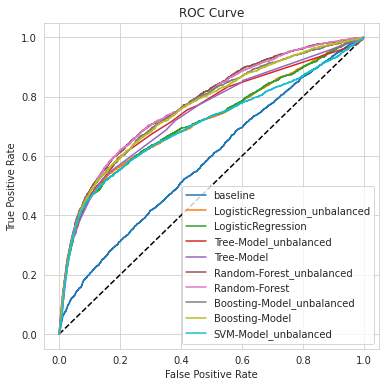

,Model,F1_score,AUC
0,baseline,0.001003,0.642373
1,LogisticRegression_unbalanced,0.359517,0.715106
2,LogisticRegression,0.465083,0.714262
3,Tree-Model_unbalanced,0.460363,0.744358
4,Tree-Model,0.512369,0.741218
5,Random-Forest_unbalanced,0.458417,0.776204
6,Random-Forest,0.526469,0.773831
7,Boosting-Model_unbalanced,0.452156,0.764917
8,Boosting-Model,0.517039,0.761915
9,SVM-Model_unbalanced,0.389573,0.704630


In [190]:
calculate_metrics(svm_model, 'SVM-Model_unbalanced')

##Po undersamplingu

In [200]:
params = {'C':[ 0.01, 0.1, 1]}
svm_model_under = SVC(kernel='poly', probability=True)

svm_model_under_gridsearch = GridSearchCV(svm_model_under, 
                                                params,
                                                scoring='f1_macro',
                                                cv=10,
                                                verbose=10,
                                                n_jobs=-1)

#verbose - ma znaczenie dla wyświetlania, jeśli modele dłużej się uczą, otrzymujemy w którym momencie nauki jest model
svm_model_under_gridsearch.fit(X_train_under, y_train_under)
print('\nBest hyperparameter:', svm_model_under_gridsearch.best_params_)

svm_model_under = svm_model_under_gridsearch.best_estimator_

Fitting 10 folds for each of 3 candidates, totalling 30 fits

Best hyperparameter: {'C': 1}


              precision    recall  f1-score   support

           0       0.86      0.85      0.86      7009
           1       0.51      0.53      0.52      1991

    accuracy                           0.78      9000
   macro avg       0.69      0.69      0.69      9000
weighted avg       0.79      0.78      0.78      9000



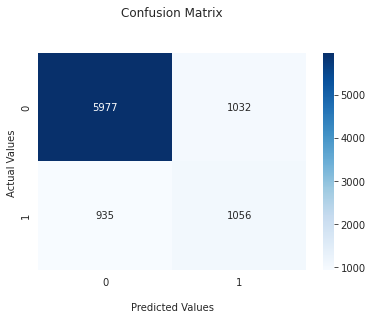

NotFittedError: ignored

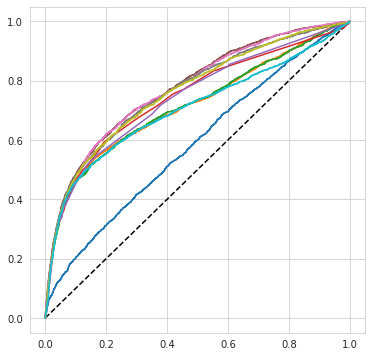

In [201]:
calculate_metrics(svm_model_under, 'SVM-Model')